In [1]:
# To setup everything (on the bash terminal to execute jupyter nb)
# !./install.sh
# !. ./env.sh
# !which python
# !jupyter notebook --ip="0.0.0.0" 

In [21]:
import demo

synt_model_dict = {
    "16": "g_00086000",
    "32": "g_00068000",
    "48": "g_00086000",
    "64": "g_00058000",
    "128": "g_00087000",
    "256": "g_00080000",
    "768": "g_00079000",
}

models = []

synthesis_model, synthesis_sr, synthesis_gen_model = demo.init_speech_synthesis_model(
    "checkpoints/lj_vq_tdnnf_asr/config.json",
    "checkpoints/lj_vq_tdnnf_asr/g_00080000",
    root_dir="speech-resynthesis/",
)

pk_model = demo.init_pkwrap_model(
    model="local/chain/e2e/tuning/tdnnf.py",
    exp_path="exp/chain/e2e_tdnnf/",
    pkwrap_vq_dim="-1",
)

models.append({"asr": pk_model, "synthesis": synthesis_model, "dim": "no_vq"})

for dim, synt_model in synt_model_dict.items():
    synthesis_model, synthesis_sr, _ = demo.init_speech_synthesis_model(
        f"checkpoints/lj_vq_tdnnf_asr_vq_{dim}/config.json",
        f"checkpoints/lj_vq_tdnnf_asr_vq_{dim}/{synt_model}",
        root_dir="speech-resynthesis/",
    )

    pk_model = demo.init_pkwrap_model(
        model=f"local/chain/e2e/tuning/tdnnf_vq.py",
        exp_path=f"exp/chain/e2e_tdnnf_vq_sizeco_{dim}/",
        pkwrap_vq_dim=dim,
    )

    models.append({f"asr": pk_model, "synthesis": synthesis_model, "dim": dim})


Loading 'checkpoints/lj_vq_tdnnf_asr/g_00080000'
Loading 'exp/chain/e2e_tdnnf/final.pt'
Loading 'checkpoints/lj_vq_tdnnf_asr_vq_16/g_00086000'
Loading 'exp/chain/e2e_tdnnf_vq_sizeco_16/final.pt'


FileNotFoundError: [Errno 2] No such file or directory: '/lium/raid01_b/pchampi/lab/asr-based-privacy-preserving-separation/pkwrap/pkwrap/../egs/librispeech/v1/exp/chain/e2e_tdnnf_vq_sizeco_16/num_pdfs'

In [10]:
from ipywebrtc import AudioRecorder, CameraStream
import torch, torchaudio, os, tempfile, subprocess
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from IPython.display import Audio, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

In [11]:
recordid="001"

text_gt = subprocess.check_output(f"cat pkwrap/egs/librispeech/v1/data/vctk_test_trials_f_common/text | head -n{recordid} | tail -n1 | cut -d\  -f2-", shell=True).decode("UTF-8").strip()
print(text_gt)
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
display(recorder)

PLEASE CALL STELLA


AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [12]:
# Recorded Audio from previous cell

if len(recorder.audio.value) != 0:
    tmpf = tempfile.NamedTemporaryFile(suffix='.webm')
    tmpfwav = tempfile.NamedTemporaryFile(suffix='.wav').name
    tmpf.write(recorder.audio.value)
    webm = tmpf.name
    !ffmpeg -i $webm -ac 1 -f wav $tmpfwav -y -hide_banner -loglevel panic 
    tmpf.close()
    waveform, sr = torchaudio.load(tmpfwav)

else:
    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/data/vctk_test/wav/p226/p226_{recordid}_mic2.wav")

    waveform, sr = torchaudio.load(f"speech-resynthesis/data/LJSpeech-1.1/wavs_16khz/LJ001-0011.wav")
    text_gt = "IT IS OF THE FIRST IMPORTANCE THAT THE LETTER USED SHOULD BE FINE IN FORM"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/2414/128292/2414-128292-0015.flac")
    # text_gt = "WHEN THE DEVIL CASTETH HIS SKIN DOTH NOT HIS NAME ALSO FALL AWAY IT IS ALSO SKIN"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/2414/128292/2414-128292-0018.flac")
    # text_gt = "THEN ONLY DID I HIT THE TRUTH"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/1688/142285/1688-142285-0015.flac")
    # text_gt = "HOW TAINTED ASKED HER FATHER"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/test-other/6938/70848/6938-70848-0012.flac")
    # text_gt = "WHEREUPON THE OLD EXECUTIVE COMMITTEE LEFT THE HALL"

    # waveform, sr = torchaudio.load(f"speech-resynthesis/data/LJSpeech-1.1/wavs_16khz/LJ001-0011.wav")
    # text_gt = "IT IS OF THE FIRST IMPORTANCE THAT THE LETTER USED SHOULD BE FINE IN FORM"

    # waveform, sr = torchaudio.load(f"pkwrap/egs/librispeech/v1/corpora/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac")
    # text_gt = "MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL"


waveform = torchaudio.transforms.Resample(orig_freq=sr,
                                                   new_freq=16000)(waveform)
waveform = waveform.to(device)
Audio(data=waveform.cpu(), rate=16000)

In [6]:
vq_model = "32"
out, net = models[list(synt_model_dict.keys()).index(vq_model)+1]["asr"](waveform.to(device).clone())

vq_model = "32"
_out, _net = models[(["no_vq"] + list(synt_model_dict.keys())).index(vq_model)]["asr"](waveform.to(device).clone())
_text, align = demo.kaldi_asr_decode(_out, get_align=True)
print(_text)


IT IS OF THE FIRST TO LAST AT THE LONGIN FOR


In [7]:
import demo
_pk_model, module  = demo.init_pkwrap_model(
    model="local/chain/e2e/tuning/tdnnf_wav2vec_vq.py",
    exp_path="exp/chain/e2e_tdnnf_wav2vec_vq_32/",
    pkwrap_vq_dim="32",
    get_model_module=True,
)

_out, net = _pk_model(waveform.to(device).clone())
_text, align = demo.kaldi_asr_decode(_out, get_align=True)
print(_text)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443


Loading 'exp/chain/e2e_tdnnf_wav2vec_vq_32/final.pt'


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/wav2vec2-base-960h/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/wav2vec2-base-960h/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/wav2vec2-base-960h/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

TIS OF THEE FIRST IMPORTANCE THAT THE LETTER USED SHOULD BE FINE IN FORM


In [8]:
def forward_from_bn(bn, module):
    with torch.no_grad():
        x = module.prefinal_chain_vq.tdnn.linearA(bn)
        x = x.permute(0, 2, 1)
        x = module.prefinal_chain_vq.bn(x)
        x = x.permute(0, 2, 1)
        x = torch.nn.functional.relu(x)
        for i in range(len(module.tdnnfs_decode)):
            x = module.tdnnfs_decode[i](x)
        __out = module.chain_output(x)
    __text, __align = demo.kaldi_asr_decode(__out, get_align=True)
    return __out, __text, __align

assert module.prefinal_chain_vq.tdnn.use_bypass == False # If vq bottleneck

quant_id = torch.flatten(net.encoding_indices).tolist()
print(quant_id)
# quant_id = [0, 0, 0, 0, 0, 2, 2, 2, 2, 29, 19, 19, 19, 8, 18, 18, 18, 18, 18]
quant_id = [0, 0, 2, 2, 29, 19, 8, 18]
print(quant_id)
with torch.no_grad():
    bn = module.quant.embedding(torch.tensor(quant_id, device=device)).unsqueeze(0)

# print(bn)
# print(net.bottleneck_out)
# print((bn - net.bottleneck_out).sum())
# assert torch.allclose(bn, net.bottleneck_out, atol=1e-5), (bn - net.bottleneck_out).sum() # Close to absolute tolerance

__out, __text, _ = forward_from_bn(bn, module)
print(__text)
# assert _text == __text

[30, 19, 19, 19, 6, 4, 21, 12, 1, 8, 1, 28, 14, 23, 10, 7, 30, 6, 26, 2, 24, 24, 7, 21, 21, 23, 23, 0, 0, 0, 0, 1, 13, 21, 7, 7, 29, 0, 27, 10, 7, 14, 0, 30, 20, 15, 0, 4, 5, 7, 4, 18, 18, 5, 15, 29, 1, 1, 28, 28, 20, 0, 22, 30, 6, 22, 0, 1, 7, 28, 27, 24, 0, 26, 0, 14, 14, 18, 18, 18, 18, 18]
[0, 0, 2, 2, 29, 19, 8, 18]
PIERRE


In [8]:
import demo
_pk_model, module  = demo.init_pkwrap_model(
    model="local/chain/e2e/tuning/tdnnf_wav2vec_vq.py",
    exp_path="exp/chain/e2e_tdnnf_wav2vec_vq_32/",
    pkwrap_vq_dim="32",
    get_model_module=True,
)
module.eval()
with torch.no_grad():
    
   

    old = -1
    fold = -1
    for i in range(720, 98999, 10):
        _inputs = torch.rand([10, i], device=device)
        x = module.preprocessor(_inputs)
        if old != x.shape[1]:
            print(i, x.shape, i/x.shape[1])
            old = x.shape[1]
            
            
            
        _out, net = _pk_model(_inputs.clone())
        if fold != len(net.encoding_indices):
            print("m", i, len(net.encoding_indices), i/len(net.encoding_indices))
            fold = len(net.encoding_indices)

Loading 'exp/chain/e2e_tdnnf_wav2vec_vq_32/final.pt'
720 torch.Size([10, 2, 768]) 360.0
m 720 70 10.285714285714286
1040 torch.Size([10, 3, 768]) 346.6666666666667
1360 torch.Size([10, 4, 768]) 340.0
m 1360 80 17.0
1680 torch.Size([10, 5, 768]) 336.0
2000 torch.Size([10, 6, 768]) 333.3333333333333
2320 torch.Size([10, 7, 768]) 331.42857142857144
m 2320 90 25.77777777777778
2640 torch.Size([10, 8, 768]) 330.0
2960 torch.Size([10, 9, 768]) 328.8888888888889
3280 torch.Size([10, 10, 768]) 328.0
m 3280 100 32.8
3600 torch.Size([10, 11, 768]) 327.27272727272725
3920 torch.Size([10, 12, 768]) 326.6666666666667
4240 torch.Size([10, 13, 768]) 326.15384615384613
m 4240 110 38.54545454545455
4560 torch.Size([10, 14, 768]) 325.7142857142857
4880 torch.Size([10, 15, 768]) 325.3333333333333
5200 torch.Size([10, 16, 768]) 325.0
m 5200 120 43.333333333333336
5520 torch.Size([10, 17, 768]) 324.70588235294116
5840 torch.Size([10, 18, 768]) 324.44444444444446
6160 torch.Size([10, 19, 768]) 324.210526315

45520 torch.Size([10, 142, 768]) 320.5633802816901
m 45520 540 84.29629629629629
45840 torch.Size([10, 143, 768]) 320.55944055944053
46160 torch.Size([10, 144, 768]) 320.55555555555554
46480 torch.Size([10, 145, 768]) 320.55172413793105
m 46480 550 84.50909090909092
46800 torch.Size([10, 146, 768]) 320.54794520547944
47120 torch.Size([10, 147, 768]) 320.5442176870748
47440 torch.Size([10, 148, 768]) 320.5405405405405
m 47440 560 84.71428571428571
47760 torch.Size([10, 149, 768]) 320.53691275167785
48080 torch.Size([10, 150, 768]) 320.53333333333336
48400 torch.Size([10, 151, 768]) 320.5298013245033
m 48400 570 84.91228070175438
48720 torch.Size([10, 152, 768]) 320.5263157894737
49040 torch.Size([10, 153, 768]) 320.52287581699346
49360 torch.Size([10, 154, 768]) 320.5194805194805
m 49360 580 85.10344827586206
49680 torch.Size([10, 155, 768]) 320.51612903225805
50000 torch.Size([10, 156, 768]) 320.5128205128205
50320 torch.Size([10, 157, 768]) 320.50955414012736
m 50320 590 85.2881355932

88720 torch.Size([10, 277, 768]) 320.28880866425993
m 88720 990 89.61616161616162
89040 torch.Size([10, 278, 768]) 320.28776978417267
89360 torch.Size([10, 279, 768]) 320.2867383512545
89680 torch.Size([10, 280, 768]) 320.2857142857143
m 89680 1000 89.68
90000 torch.Size([10, 281, 768]) 320.2846975088968
90320 torch.Size([10, 282, 768]) 320.2836879432624
90640 torch.Size([10, 283, 768]) 320.2826855123675
m 90640 1010 89.74257425742574
90960 torch.Size([10, 284, 768]) 320.28169014084506
91280 torch.Size([10, 285, 768]) 320.280701754386
91600 torch.Size([10, 286, 768]) 320.27972027972027
m 91600 1020 89.80392156862744
91920 torch.Size([10, 287, 768]) 320.2787456445993
92240 torch.Size([10, 288, 768]) 320.27777777777777
92560 torch.Size([10, 289, 768]) 320.2768166089965
m 92560 1030 89.86407766990291
92880 torch.Size([10, 290, 768]) 320.2758620689655
93200 torch.Size([10, 291, 768]) 320.2749140893471
93520 torch.Size([10, 292, 768]) 320.2739726027397
m 93520 1040 89.92307692307692
93840 t

In [5]:

from transformers import Wav2Vec2Model, Wav2Vec2Processor
import torch
    
wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").cuda()
with torch.no_grad():
    for i in range(16000, 16000*3, 1):
        _inputs = torch.rand([1, i]).cuda()
        _o = wav2vec2(_inputs)
        
        print(i, _o.last_hidden_state.shape, i/_o.last_hidden_state.shape[1])


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


16000 torch.Size([1, 49, 768]) 326.53061224489795
16001 torch.Size([1, 49, 768]) 326.55102040816325
16002 torch.Size([1, 49, 768]) 326.57142857142856
16003 torch.Size([1, 49, 768]) 326.59183673469386
16004 torch.Size([1, 49, 768]) 326.61224489795916
16005 torch.Size([1, 49, 768]) 326.6326530612245
16006 torch.Size([1, 49, 768]) 326.6530612244898
16007 torch.Size([1, 49, 768]) 326.6734693877551
16008 torch.Size([1, 49, 768]) 326.6938775510204
16009 torch.Size([1, 49, 768]) 326.7142857142857
16010 torch.Size([1, 49, 768]) 326.734693877551
16011 torch.Size([1, 49, 768]) 326.7551020408163
16012 torch.Size([1, 49, 768]) 326.7755102040816
16013 torch.Size([1, 49, 768]) 326.7959183673469
16014 torch.Size([1, 49, 768]) 326.81632653061223
16015 torch.Size([1, 49, 768]) 326.83673469387753
16016 torch.Size([1, 49, 768]) 326.85714285714283
16017 torch.Size([1, 49, 768]) 326.8775510204082
16018 torch.Size([1, 49, 768]) 326.8979591836735
16019 torch.Size([1, 49, 768]) 326.9183673469388
16020 torch.S

16202 torch.Size([1, 50, 768]) 324.04
16203 torch.Size([1, 50, 768]) 324.06
16204 torch.Size([1, 50, 768]) 324.08
16205 torch.Size([1, 50, 768]) 324.1
16206 torch.Size([1, 50, 768]) 324.12
16207 torch.Size([1, 50, 768]) 324.14
16208 torch.Size([1, 50, 768]) 324.16
16209 torch.Size([1, 50, 768]) 324.18
16210 torch.Size([1, 50, 768]) 324.2
16211 torch.Size([1, 50, 768]) 324.22
16212 torch.Size([1, 50, 768]) 324.24
16213 torch.Size([1, 50, 768]) 324.26
16214 torch.Size([1, 50, 768]) 324.28
16215 torch.Size([1, 50, 768]) 324.3
16216 torch.Size([1, 50, 768]) 324.32
16217 torch.Size([1, 50, 768]) 324.34
16218 torch.Size([1, 50, 768]) 324.36
16219 torch.Size([1, 50, 768]) 324.38
16220 torch.Size([1, 50, 768]) 324.4
16221 torch.Size([1, 50, 768]) 324.42
16222 torch.Size([1, 50, 768]) 324.44
16223 torch.Size([1, 50, 768]) 324.46
16224 torch.Size([1, 50, 768]) 324.48
16225 torch.Size([1, 50, 768]) 324.5
16226 torch.Size([1, 50, 768]) 324.52
16227 torch.Size([1, 50, 768]) 324.54
16228 torch.Size(

16424 torch.Size([1, 51, 768]) 322.03921568627453
16425 torch.Size([1, 51, 768]) 322.05882352941177
16426 torch.Size([1, 51, 768]) 322.078431372549
16427 torch.Size([1, 51, 768]) 322.0980392156863
16428 torch.Size([1, 51, 768]) 322.11764705882354
16429 torch.Size([1, 51, 768]) 322.1372549019608
16430 torch.Size([1, 51, 768]) 322.15686274509807
16431 torch.Size([1, 51, 768]) 322.1764705882353
16432 torch.Size([1, 51, 768]) 322.19607843137254
16433 torch.Size([1, 51, 768]) 322.2156862745098
16434 torch.Size([1, 51, 768]) 322.2352941176471
16435 torch.Size([1, 51, 768]) 322.2549019607843
16436 torch.Size([1, 51, 768]) 322.27450980392155
16437 torch.Size([1, 51, 768]) 322.29411764705884
16438 torch.Size([1, 51, 768]) 322.3137254901961
16439 torch.Size([1, 51, 768]) 322.3333333333333
16440 torch.Size([1, 51, 768]) 322.3529411764706
16441 torch.Size([1, 51, 768]) 322.37254901960785
16442 torch.Size([1, 51, 768]) 322.3921568627451
16443 torch.Size([1, 51, 768]) 322.4117647058824
16444 torch.S

16600 torch.Size([1, 51, 768]) 325.4901960784314
16601 torch.Size([1, 51, 768]) 325.5098039215686
16602 torch.Size([1, 51, 768]) 325.52941176470586
16603 torch.Size([1, 51, 768]) 325.54901960784315
16604 torch.Size([1, 51, 768]) 325.5686274509804
16605 torch.Size([1, 51, 768]) 325.5882352941176
16606 torch.Size([1, 51, 768]) 325.6078431372549
16607 torch.Size([1, 51, 768]) 325.62745098039215
16608 torch.Size([1, 51, 768]) 325.6470588235294
16609 torch.Size([1, 51, 768]) 325.6666666666667
16610 torch.Size([1, 51, 768]) 325.6862745098039
16611 torch.Size([1, 51, 768]) 325.70588235294116
16612 torch.Size([1, 51, 768]) 325.72549019607845
16613 torch.Size([1, 51, 768]) 325.7450980392157
16614 torch.Size([1, 51, 768]) 325.7647058823529
16615 torch.Size([1, 51, 768]) 325.7843137254902
16616 torch.Size([1, 51, 768]) 325.80392156862746
16617 torch.Size([1, 51, 768]) 325.8235294117647
16618 torch.Size([1, 51, 768]) 325.84313725490193
16619 torch.Size([1, 51, 768]) 325.8627450980392
16620 torch.S

16779 torch.Size([1, 52, 768]) 322.6730769230769
16780 torch.Size([1, 52, 768]) 322.6923076923077
16781 torch.Size([1, 52, 768]) 322.71153846153845
16782 torch.Size([1, 52, 768]) 322.7307692307692
16783 torch.Size([1, 52, 768]) 322.75
16784 torch.Size([1, 52, 768]) 322.7692307692308
16785 torch.Size([1, 52, 768]) 322.78846153846155
16786 torch.Size([1, 52, 768]) 322.8076923076923
16787 torch.Size([1, 52, 768]) 322.8269230769231
16788 torch.Size([1, 52, 768]) 322.84615384615387
16789 torch.Size([1, 52, 768]) 322.86538461538464
16790 torch.Size([1, 52, 768]) 322.88461538461536
16791 torch.Size([1, 52, 768]) 322.90384615384613
16792 torch.Size([1, 52, 768]) 322.9230769230769
16793 torch.Size([1, 52, 768]) 322.9423076923077
16794 torch.Size([1, 52, 768]) 322.96153846153845
16795 torch.Size([1, 52, 768]) 322.9807692307692
16796 torch.Size([1, 52, 768]) 323.0
16797 torch.Size([1, 52, 768]) 323.0192307692308
16798 torch.Size([1, 52, 768]) 323.03846153846155
16799 torch.Size([1, 52, 768]) 323.

16950 torch.Size([1, 52, 768]) 325.96153846153845
16951 torch.Size([1, 52, 768]) 325.9807692307692
16952 torch.Size([1, 52, 768]) 326.0
16953 torch.Size([1, 52, 768]) 326.0192307692308
16954 torch.Size([1, 52, 768]) 326.03846153846155
16955 torch.Size([1, 52, 768]) 326.0576923076923
16956 torch.Size([1, 52, 768]) 326.0769230769231
16957 torch.Size([1, 52, 768]) 326.09615384615387
16958 torch.Size([1, 52, 768]) 326.11538461538464
16959 torch.Size([1, 52, 768]) 326.13461538461536
16960 torch.Size([1, 52, 768]) 326.15384615384613
16961 torch.Size([1, 52, 768]) 326.1730769230769
16962 torch.Size([1, 52, 768]) 326.1923076923077
16963 torch.Size([1, 52, 768]) 326.21153846153845
16964 torch.Size([1, 52, 768]) 326.2307692307692
16965 torch.Size([1, 52, 768]) 326.25
16966 torch.Size([1, 52, 768]) 326.2692307692308
16967 torch.Size([1, 52, 768]) 326.28846153846155
16968 torch.Size([1, 52, 768]) 326.3076923076923
16969 torch.Size([1, 52, 768]) 326.3269230769231
16970 torch.Size([1, 52, 768]) 326.

17123 torch.Size([1, 53, 768]) 323.07547169811323
17124 torch.Size([1, 53, 768]) 323.0943396226415
17125 torch.Size([1, 53, 768]) 323.1132075471698
17126 torch.Size([1, 53, 768]) 323.1320754716981
17127 torch.Size([1, 53, 768]) 323.1509433962264
17128 torch.Size([1, 53, 768]) 323.1698113207547
17129 torch.Size([1, 53, 768]) 323.188679245283
17130 torch.Size([1, 53, 768]) 323.20754716981133
17131 torch.Size([1, 53, 768]) 323.22641509433964
17132 torch.Size([1, 53, 768]) 323.24528301886795
17133 torch.Size([1, 53, 768]) 323.2641509433962
17134 torch.Size([1, 53, 768]) 323.2830188679245
17135 torch.Size([1, 53, 768]) 323.3018867924528
17136 torch.Size([1, 53, 768]) 323.3207547169811
17137 torch.Size([1, 53, 768]) 323.33962264150944
17138 torch.Size([1, 53, 768]) 323.35849056603774
17139 torch.Size([1, 53, 768]) 323.37735849056605
17140 torch.Size([1, 53, 768]) 323.39622641509436
17141 torch.Size([1, 53, 768]) 323.41509433962267
17142 torch.Size([1, 53, 768]) 323.4339622641509
17143 torch.

17297 torch.Size([1, 53, 768]) 326.35849056603774
17298 torch.Size([1, 53, 768]) 326.37735849056605
17299 torch.Size([1, 53, 768]) 326.39622641509436
17300 torch.Size([1, 53, 768]) 326.41509433962267
17301 torch.Size([1, 53, 768]) 326.4339622641509
17302 torch.Size([1, 53, 768]) 326.45283018867923
17303 torch.Size([1, 53, 768]) 326.47169811320754
17304 torch.Size([1, 53, 768]) 326.49056603773585
17305 torch.Size([1, 53, 768]) 326.50943396226415
17306 torch.Size([1, 53, 768]) 326.52830188679246
17307 torch.Size([1, 53, 768]) 326.54716981132077
17308 torch.Size([1, 53, 768]) 326.5660377358491
17309 torch.Size([1, 53, 768]) 326.58490566037733
17310 torch.Size([1, 53, 768]) 326.60377358490564
17311 torch.Size([1, 53, 768]) 326.62264150943395
17312 torch.Size([1, 53, 768]) 326.64150943396226
17313 torch.Size([1, 53, 768]) 326.66037735849056
17314 torch.Size([1, 53, 768]) 326.6792452830189
17315 torch.Size([1, 53, 768]) 326.6981132075472
17316 torch.Size([1, 53, 768]) 326.7169811320755
17317

17472 torch.Size([1, 54, 768]) 323.55555555555554
17473 torch.Size([1, 54, 768]) 323.5740740740741
17474 torch.Size([1, 54, 768]) 323.5925925925926
17475 torch.Size([1, 54, 768]) 323.6111111111111
17476 torch.Size([1, 54, 768]) 323.6296296296296
17477 torch.Size([1, 54, 768]) 323.64814814814815
17478 torch.Size([1, 54, 768]) 323.6666666666667
17479 torch.Size([1, 54, 768]) 323.68518518518516
17480 torch.Size([1, 54, 768]) 323.7037037037037
17481 torch.Size([1, 54, 768]) 323.72222222222223
17482 torch.Size([1, 54, 768]) 323.74074074074076
17483 torch.Size([1, 54, 768]) 323.75925925925924
17484 torch.Size([1, 54, 768]) 323.77777777777777
17485 torch.Size([1, 54, 768]) 323.7962962962963
17486 torch.Size([1, 54, 768]) 323.81481481481484
17487 torch.Size([1, 54, 768]) 323.8333333333333
17488 torch.Size([1, 54, 768]) 323.85185185185185
17489 torch.Size([1, 54, 768]) 323.8703703703704
17490 torch.Size([1, 54, 768]) 323.8888888888889
17491 torch.Size([1, 54, 768]) 323.9074074074074
17492 torch

17651 torch.Size([1, 54, 768]) 326.8703703703704
17652 torch.Size([1, 54, 768]) 326.8888888888889
17653 torch.Size([1, 54, 768]) 326.9074074074074
17654 torch.Size([1, 54, 768]) 326.9259259259259
17655 torch.Size([1, 54, 768]) 326.94444444444446
17656 torch.Size([1, 54, 768]) 326.962962962963
17657 torch.Size([1, 54, 768]) 326.98148148148147
17658 torch.Size([1, 54, 768]) 327.0
17659 torch.Size([1, 54, 768]) 327.01851851851853
17660 torch.Size([1, 54, 768]) 327.037037037037
17661 torch.Size([1, 54, 768]) 327.05555555555554
17662 torch.Size([1, 54, 768]) 327.0740740740741
17663 torch.Size([1, 54, 768]) 327.0925925925926
17664 torch.Size([1, 54, 768]) 327.1111111111111
17665 torch.Size([1, 54, 768]) 327.1296296296296
17666 torch.Size([1, 54, 768]) 327.14814814814815
17667 torch.Size([1, 54, 768]) 327.1666666666667
17668 torch.Size([1, 54, 768]) 327.18518518518516
17669 torch.Size([1, 54, 768]) 327.2037037037037
17670 torch.Size([1, 54, 768]) 327.22222222222223
17671 torch.Size([1, 54, 76

17821 torch.Size([1, 55, 768]) 324.0181818181818
17822 torch.Size([1, 55, 768]) 324.03636363636366
17823 torch.Size([1, 55, 768]) 324.05454545454546
17824 torch.Size([1, 55, 768]) 324.07272727272726
17825 torch.Size([1, 55, 768]) 324.09090909090907
17826 torch.Size([1, 55, 768]) 324.1090909090909
17827 torch.Size([1, 55, 768]) 324.1272727272727
17828 torch.Size([1, 55, 768]) 324.1454545454545
17829 torch.Size([1, 55, 768]) 324.1636363636364
17830 torch.Size([1, 55, 768]) 324.1818181818182
17831 torch.Size([1, 55, 768]) 324.2
17832 torch.Size([1, 55, 768]) 324.2181818181818
17833 torch.Size([1, 55, 768]) 324.23636363636365
17834 torch.Size([1, 55, 768]) 324.25454545454545
17835 torch.Size([1, 55, 768]) 324.27272727272725
17836 torch.Size([1, 55, 768]) 324.2909090909091
17837 torch.Size([1, 55, 768]) 324.3090909090909
17838 torch.Size([1, 55, 768]) 324.3272727272727
17839 torch.Size([1, 55, 768]) 324.3454545454546
17840 torch.Size([1, 55, 768]) 324.3636363636364
17841 torch.Size([1, 55, 

17993 torch.Size([1, 55, 768]) 327.1454545454545
17994 torch.Size([1, 55, 768]) 327.1636363636364
17995 torch.Size([1, 55, 768]) 327.1818181818182
17996 torch.Size([1, 55, 768]) 327.2
17997 torch.Size([1, 55, 768]) 327.2181818181818
17998 torch.Size([1, 55, 768]) 327.23636363636365
17999 torch.Size([1, 55, 768]) 327.25454545454545
18000 torch.Size([1, 56, 768]) 321.42857142857144
18001 torch.Size([1, 56, 768]) 321.44642857142856
18002 torch.Size([1, 56, 768]) 321.4642857142857
18003 torch.Size([1, 56, 768]) 321.48214285714283
18004 torch.Size([1, 56, 768]) 321.5
18005 torch.Size([1, 56, 768]) 321.51785714285717
18006 torch.Size([1, 56, 768]) 321.5357142857143
18007 torch.Size([1, 56, 768]) 321.55357142857144
18008 torch.Size([1, 56, 768]) 321.57142857142856
18009 torch.Size([1, 56, 768]) 321.5892857142857
18010 torch.Size([1, 56, 768]) 321.60714285714283
18011 torch.Size([1, 56, 768]) 321.625
18012 torch.Size([1, 56, 768]) 321.64285714285717
18013 torch.Size([1, 56, 768]) 321.660714285

18165 torch.Size([1, 56, 768]) 324.375
18166 torch.Size([1, 56, 768]) 324.39285714285717
18167 torch.Size([1, 56, 768]) 324.4107142857143
18168 torch.Size([1, 56, 768]) 324.42857142857144
18169 torch.Size([1, 56, 768]) 324.44642857142856
18170 torch.Size([1, 56, 768]) 324.4642857142857
18171 torch.Size([1, 56, 768]) 324.48214285714283
18172 torch.Size([1, 56, 768]) 324.5
18173 torch.Size([1, 56, 768]) 324.51785714285717
18174 torch.Size([1, 56, 768]) 324.5357142857143
18175 torch.Size([1, 56, 768]) 324.55357142857144
18176 torch.Size([1, 56, 768]) 324.57142857142856
18177 torch.Size([1, 56, 768]) 324.5892857142857
18178 torch.Size([1, 56, 768]) 324.60714285714283
18179 torch.Size([1, 56, 768]) 324.625
18180 torch.Size([1, 56, 768]) 324.64285714285717
18181 torch.Size([1, 56, 768]) 324.6607142857143
18182 torch.Size([1, 56, 768]) 324.67857142857144
18183 torch.Size([1, 56, 768]) 324.69642857142856
18184 torch.Size([1, 56, 768]) 324.7142857142857
18185 torch.Size([1, 56, 768]) 324.732142

18337 torch.Size([1, 57, 768]) 321.70175438596493
18338 torch.Size([1, 57, 768]) 321.719298245614
18339 torch.Size([1, 57, 768]) 321.7368421052632
18340 torch.Size([1, 57, 768]) 321.7543859649123
18341 torch.Size([1, 57, 768]) 321.7719298245614
18342 torch.Size([1, 57, 768]) 321.7894736842105
18343 torch.Size([1, 57, 768]) 321.8070175438597
18344 torch.Size([1, 57, 768]) 321.82456140350877
18345 torch.Size([1, 57, 768]) 321.8421052631579
18346 torch.Size([1, 57, 768]) 321.859649122807
18347 torch.Size([1, 57, 768]) 321.87719298245617
18348 torch.Size([1, 57, 768]) 321.89473684210526
18349 torch.Size([1, 57, 768]) 321.9122807017544
18350 torch.Size([1, 57, 768]) 321.9298245614035
18351 torch.Size([1, 57, 768]) 321.94736842105266
18352 torch.Size([1, 57, 768]) 321.96491228070175
18353 torch.Size([1, 57, 768]) 321.9824561403509
18354 torch.Size([1, 57, 768]) 322.0
18355 torch.Size([1, 57, 768]) 322.0175438596491
18356 torch.Size([1, 57, 768]) 322.03508771929825
18357 torch.Size([1, 57, 76

18508 torch.Size([1, 57, 768]) 324.70175438596493
18509 torch.Size([1, 57, 768]) 324.719298245614
18510 torch.Size([1, 57, 768]) 324.7368421052632
18511 torch.Size([1, 57, 768]) 324.7543859649123
18512 torch.Size([1, 57, 768]) 324.7719298245614
18513 torch.Size([1, 57, 768]) 324.7894736842105
18514 torch.Size([1, 57, 768]) 324.8070175438597
18515 torch.Size([1, 57, 768]) 324.82456140350877
18516 torch.Size([1, 57, 768]) 324.8421052631579
18517 torch.Size([1, 57, 768]) 324.859649122807
18518 torch.Size([1, 57, 768]) 324.87719298245617
18519 torch.Size([1, 57, 768]) 324.89473684210526
18520 torch.Size([1, 57, 768]) 324.9122807017544
18521 torch.Size([1, 57, 768]) 324.9298245614035
18522 torch.Size([1, 57, 768]) 324.94736842105266
18523 torch.Size([1, 57, 768]) 324.96491228070175
18524 torch.Size([1, 57, 768]) 324.9824561403509
18525 torch.Size([1, 57, 768]) 325.0
18526 torch.Size([1, 57, 768]) 325.0175438596491
18527 torch.Size([1, 57, 768]) 325.03508771929825
18528 torch.Size([1, 57, 76

18681 torch.Size([1, 58, 768]) 322.08620689655174
18682 torch.Size([1, 58, 768]) 322.1034482758621
18683 torch.Size([1, 58, 768]) 322.12068965517244
18684 torch.Size([1, 58, 768]) 322.13793103448273
18685 torch.Size([1, 58, 768]) 322.1551724137931
18686 torch.Size([1, 58, 768]) 322.17241379310343
18687 torch.Size([1, 58, 768]) 322.1896551724138
18688 torch.Size([1, 58, 768]) 322.2068965517241
18689 torch.Size([1, 58, 768]) 322.2241379310345
18690 torch.Size([1, 58, 768]) 322.2413793103448
18691 torch.Size([1, 58, 768]) 322.2586206896552
18692 torch.Size([1, 58, 768]) 322.2758620689655
18693 torch.Size([1, 58, 768]) 322.2931034482759
18694 torch.Size([1, 58, 768]) 322.3103448275862
18695 torch.Size([1, 58, 768]) 322.32758620689657
18696 torch.Size([1, 58, 768]) 322.3448275862069
18697 torch.Size([1, 58, 768]) 322.36206896551727
18698 torch.Size([1, 58, 768]) 322.37931034482756
18699 torch.Size([1, 58, 768]) 322.3965517241379
18700 torch.Size([1, 58, 768]) 322.41379310344826
18701 torch.

18852 torch.Size([1, 58, 768]) 325.0344827586207
18853 torch.Size([1, 58, 768]) 325.05172413793105
18854 torch.Size([1, 58, 768]) 325.0689655172414
18855 torch.Size([1, 58, 768]) 325.08620689655174
18856 torch.Size([1, 58, 768]) 325.1034482758621
18857 torch.Size([1, 58, 768]) 325.12068965517244
18858 torch.Size([1, 58, 768]) 325.13793103448273
18859 torch.Size([1, 58, 768]) 325.1551724137931
18860 torch.Size([1, 58, 768]) 325.17241379310343
18861 torch.Size([1, 58, 768]) 325.1896551724138
18862 torch.Size([1, 58, 768]) 325.2068965517241
18863 torch.Size([1, 58, 768]) 325.2241379310345
18864 torch.Size([1, 58, 768]) 325.2413793103448
18865 torch.Size([1, 58, 768]) 325.2586206896552
18866 torch.Size([1, 58, 768]) 325.2758620689655
18867 torch.Size([1, 58, 768]) 325.2931034482759
18868 torch.Size([1, 58, 768]) 325.3103448275862
18869 torch.Size([1, 58, 768]) 325.32758620689657
18870 torch.Size([1, 58, 768]) 325.3448275862069
18871 torch.Size([1, 58, 768]) 325.36206896551727
18872 torch.S

19026 torch.Size([1, 59, 768]) 322.47457627118644
19027 torch.Size([1, 59, 768]) 322.49152542372883
19028 torch.Size([1, 59, 768]) 322.50847457627117
19029 torch.Size([1, 59, 768]) 322.52542372881356
19030 torch.Size([1, 59, 768]) 322.54237288135596
19031 torch.Size([1, 59, 768]) 322.5593220338983
19032 torch.Size([1, 59, 768]) 322.5762711864407
19033 torch.Size([1, 59, 768]) 322.59322033898303
19034 torch.Size([1, 59, 768]) 322.6101694915254
19035 torch.Size([1, 59, 768]) 322.6271186440678
19036 torch.Size([1, 59, 768]) 322.64406779661016
19037 torch.Size([1, 59, 768]) 322.66101694915255
19038 torch.Size([1, 59, 768]) 322.6779661016949
19039 torch.Size([1, 59, 768]) 322.6949152542373
19040 torch.Size([1, 59, 768]) 322.7118644067797
19041 torch.Size([1, 59, 768]) 322.728813559322
19042 torch.Size([1, 59, 768]) 322.7457627118644
19043 torch.Size([1, 59, 768]) 322.76271186440675
19044 torch.Size([1, 59, 768]) 322.77966101694915
19045 torch.Size([1, 59, 768]) 322.79661016949154
19046 torc

19200 torch.Size([1, 59, 768]) 325.4237288135593
19201 torch.Size([1, 59, 768]) 325.4406779661017
19202 torch.Size([1, 59, 768]) 325.45762711864404
19203 torch.Size([1, 59, 768]) 325.47457627118644
19204 torch.Size([1, 59, 768]) 325.49152542372883
19205 torch.Size([1, 59, 768]) 325.50847457627117
19206 torch.Size([1, 59, 768]) 325.52542372881356
19207 torch.Size([1, 59, 768]) 325.54237288135596
19208 torch.Size([1, 59, 768]) 325.5593220338983
19209 torch.Size([1, 59, 768]) 325.5762711864407
19210 torch.Size([1, 59, 768]) 325.59322033898303
19211 torch.Size([1, 59, 768]) 325.6101694915254
19212 torch.Size([1, 59, 768]) 325.6271186440678
19213 torch.Size([1, 59, 768]) 325.64406779661016
19214 torch.Size([1, 59, 768]) 325.66101694915255
19215 torch.Size([1, 59, 768]) 325.6779661016949
19216 torch.Size([1, 59, 768]) 325.6949152542373
19217 torch.Size([1, 59, 768]) 325.7118644067797
19218 torch.Size([1, 59, 768]) 325.728813559322
19219 torch.Size([1, 59, 768]) 325.7457627118644
19220 torch.

19376 torch.Size([1, 60, 768]) 322.93333333333334
19377 torch.Size([1, 60, 768]) 322.95
19378 torch.Size([1, 60, 768]) 322.96666666666664
19379 torch.Size([1, 60, 768]) 322.98333333333335
19380 torch.Size([1, 60, 768]) 323.0
19381 torch.Size([1, 60, 768]) 323.01666666666665
19382 torch.Size([1, 60, 768]) 323.03333333333336
19383 torch.Size([1, 60, 768]) 323.05
19384 torch.Size([1, 60, 768]) 323.06666666666666
19385 torch.Size([1, 60, 768]) 323.0833333333333
19386 torch.Size([1, 60, 768]) 323.1
19387 torch.Size([1, 60, 768]) 323.1166666666667
19388 torch.Size([1, 60, 768]) 323.1333333333333
19389 torch.Size([1, 60, 768]) 323.15
19390 torch.Size([1, 60, 768]) 323.1666666666667
19391 torch.Size([1, 60, 768]) 323.18333333333334
19392 torch.Size([1, 60, 768]) 323.2
19393 torch.Size([1, 60, 768]) 323.21666666666664
19394 torch.Size([1, 60, 768]) 323.23333333333335
19395 torch.Size([1, 60, 768]) 323.25
19396 torch.Size([1, 60, 768]) 323.26666666666665
19397 torch.Size([1, 60, 768]) 323.283333

19566 torch.Size([1, 60, 768]) 326.1
19567 torch.Size([1, 60, 768]) 326.1166666666667
19568 torch.Size([1, 60, 768]) 326.1333333333333
19569 torch.Size([1, 60, 768]) 326.15
19570 torch.Size([1, 60, 768]) 326.1666666666667
19571 torch.Size([1, 60, 768]) 326.18333333333334
19572 torch.Size([1, 60, 768]) 326.2
19573 torch.Size([1, 60, 768]) 326.21666666666664
19574 torch.Size([1, 60, 768]) 326.23333333333335
19575 torch.Size([1, 60, 768]) 326.25
19576 torch.Size([1, 60, 768]) 326.26666666666665
19577 torch.Size([1, 60, 768]) 326.28333333333336
19578 torch.Size([1, 60, 768]) 326.3
19579 torch.Size([1, 60, 768]) 326.31666666666666
19580 torch.Size([1, 60, 768]) 326.3333333333333
19581 torch.Size([1, 60, 768]) 326.35
19582 torch.Size([1, 60, 768]) 326.3666666666667
19583 torch.Size([1, 60, 768]) 326.3833333333333
19584 torch.Size([1, 60, 768]) 326.4
19585 torch.Size([1, 60, 768]) 326.4166666666667
19586 torch.Size([1, 60, 768]) 326.43333333333334
19587 torch.Size([1, 60, 768]) 326.45
19588 t

19742 torch.Size([1, 61, 768]) 323.6393442622951
19743 torch.Size([1, 61, 768]) 323.655737704918
19744 torch.Size([1, 61, 768]) 323.672131147541
19745 torch.Size([1, 61, 768]) 323.6885245901639
19746 torch.Size([1, 61, 768]) 323.7049180327869
19747 torch.Size([1, 61, 768]) 323.72131147540983
19748 torch.Size([1, 61, 768]) 323.73770491803276
19749 torch.Size([1, 61, 768]) 323.75409836065575
19750 torch.Size([1, 61, 768]) 323.7704918032787
19751 torch.Size([1, 61, 768]) 323.78688524590166
19752 torch.Size([1, 61, 768]) 323.8032786885246
19753 torch.Size([1, 61, 768]) 323.8196721311475
19754 torch.Size([1, 61, 768]) 323.8360655737705
19755 torch.Size([1, 61, 768]) 323.8524590163934
19756 torch.Size([1, 61, 768]) 323.8688524590164
19757 torch.Size([1, 61, 768]) 323.88524590163934
19758 torch.Size([1, 61, 768]) 323.9016393442623
19759 torch.Size([1, 61, 768]) 323.91803278688525
19760 torch.Size([1, 61, 768]) 323.9344262295082
19761 torch.Size([1, 61, 768]) 323.95081967213116
19762 torch.Siz

19916 torch.Size([1, 61, 768]) 326.4918032786885
19917 torch.Size([1, 61, 768]) 326.5081967213115
19918 torch.Size([1, 61, 768]) 326.5245901639344
19919 torch.Size([1, 61, 768]) 326.5409836065574
19920 torch.Size([1, 62, 768]) 321.2903225806452
19921 torch.Size([1, 62, 768]) 321.30645161290323
19922 torch.Size([1, 62, 768]) 321.3225806451613
19923 torch.Size([1, 62, 768]) 321.33870967741933
19924 torch.Size([1, 62, 768]) 321.35483870967744
19925 torch.Size([1, 62, 768]) 321.3709677419355
19926 torch.Size([1, 62, 768]) 321.38709677419354
19927 torch.Size([1, 62, 768]) 321.4032258064516
19928 torch.Size([1, 62, 768]) 321.4193548387097
19929 torch.Size([1, 62, 768]) 321.43548387096774
19930 torch.Size([1, 62, 768]) 321.4516129032258
19931 torch.Size([1, 62, 768]) 321.46774193548384
19932 torch.Size([1, 62, 768]) 321.48387096774195
19933 torch.Size([1, 62, 768]) 321.5
19934 torch.Size([1, 62, 768]) 321.51612903225805
19935 torch.Size([1, 62, 768]) 321.53225806451616
19936 torch.Size([1, 62

20090 torch.Size([1, 62, 768]) 324.03225806451616
20091 torch.Size([1, 62, 768]) 324.0483870967742
20092 torch.Size([1, 62, 768]) 324.06451612903226
20093 torch.Size([1, 62, 768]) 324.0806451612903
20094 torch.Size([1, 62, 768]) 324.0967741935484
20095 torch.Size([1, 62, 768]) 324.11290322580646
20096 torch.Size([1, 62, 768]) 324.1290322580645
20097 torch.Size([1, 62, 768]) 324.14516129032256
20098 torch.Size([1, 62, 768]) 324.16129032258067
20099 torch.Size([1, 62, 768]) 324.1774193548387
20100 torch.Size([1, 62, 768]) 324.19354838709677
20101 torch.Size([1, 62, 768]) 324.2096774193548
20102 torch.Size([1, 62, 768]) 324.2258064516129
20103 torch.Size([1, 62, 768]) 324.241935483871
20104 torch.Size([1, 62, 768]) 324.258064516129
20105 torch.Size([1, 62, 768]) 324.2741935483871
20106 torch.Size([1, 62, 768]) 324.2903225806452
20107 torch.Size([1, 62, 768]) 324.30645161290323
20108 torch.Size([1, 62, 768]) 324.3225806451613
20109 torch.Size([1, 62, 768]) 324.33870967741933
20110 torch.Si

20267 torch.Size([1, 63, 768]) 321.6984126984127
20268 torch.Size([1, 63, 768]) 321.7142857142857
20269 torch.Size([1, 63, 768]) 321.73015873015873
20270 torch.Size([1, 63, 768]) 321.74603174603175
20271 torch.Size([1, 63, 768]) 321.76190476190476
20272 torch.Size([1, 63, 768]) 321.77777777777777
20273 torch.Size([1, 63, 768]) 321.7936507936508
20274 torch.Size([1, 63, 768]) 321.8095238095238
20275 torch.Size([1, 63, 768]) 321.8253968253968
20276 torch.Size([1, 63, 768]) 321.8412698412698
20277 torch.Size([1, 63, 768]) 321.85714285714283
20278 torch.Size([1, 63, 768]) 321.87301587301585
20279 torch.Size([1, 63, 768]) 321.8888888888889
20280 torch.Size([1, 63, 768]) 321.9047619047619
20281 torch.Size([1, 63, 768]) 321.92063492063494
20282 torch.Size([1, 63, 768]) 321.93650793650795
20283 torch.Size([1, 63, 768]) 321.95238095238096
20284 torch.Size([1, 63, 768]) 321.968253968254
20285 torch.Size([1, 63, 768]) 321.984126984127
20286 torch.Size([1, 63, 768]) 322.0
20287 torch.Size([1, 63, 

20443 torch.Size([1, 63, 768]) 324.4920634920635
20444 torch.Size([1, 63, 768]) 324.5079365079365
20445 torch.Size([1, 63, 768]) 324.5238095238095
20446 torch.Size([1, 63, 768]) 324.53968253968253
20447 torch.Size([1, 63, 768]) 324.55555555555554
20448 torch.Size([1, 63, 768]) 324.57142857142856
20449 torch.Size([1, 63, 768]) 324.58730158730157
20450 torch.Size([1, 63, 768]) 324.6031746031746
20451 torch.Size([1, 63, 768]) 324.6190476190476
20452 torch.Size([1, 63, 768]) 324.63492063492066
20453 torch.Size([1, 63, 768]) 324.6507936507937
20454 torch.Size([1, 63, 768]) 324.6666666666667
20455 torch.Size([1, 63, 768]) 324.6825396825397
20456 torch.Size([1, 63, 768]) 324.6984126984127
20457 torch.Size([1, 63, 768]) 324.7142857142857
20458 torch.Size([1, 63, 768]) 324.73015873015873
20459 torch.Size([1, 63, 768]) 324.74603174603175
20460 torch.Size([1, 63, 768]) 324.76190476190476
20461 torch.Size([1, 63, 768]) 324.77777777777777
20462 torch.Size([1, 63, 768]) 324.7936507936508
20463 torch

20632 torch.Size([1, 64, 768]) 322.375
20633 torch.Size([1, 64, 768]) 322.390625
20634 torch.Size([1, 64, 768]) 322.40625
20635 torch.Size([1, 64, 768]) 322.421875
20636 torch.Size([1, 64, 768]) 322.4375
20637 torch.Size([1, 64, 768]) 322.453125
20638 torch.Size([1, 64, 768]) 322.46875
20639 torch.Size([1, 64, 768]) 322.484375
20640 torch.Size([1, 64, 768]) 322.5
20641 torch.Size([1, 64, 768]) 322.515625
20642 torch.Size([1, 64, 768]) 322.53125
20643 torch.Size([1, 64, 768]) 322.546875
20644 torch.Size([1, 64, 768]) 322.5625
20645 torch.Size([1, 64, 768]) 322.578125
20646 torch.Size([1, 64, 768]) 322.59375
20647 torch.Size([1, 64, 768]) 322.609375
20648 torch.Size([1, 64, 768]) 322.625
20649 torch.Size([1, 64, 768]) 322.640625
20650 torch.Size([1, 64, 768]) 322.65625
20651 torch.Size([1, 64, 768]) 322.671875
20652 torch.Size([1, 64, 768]) 322.6875
20653 torch.Size([1, 64, 768]) 322.703125
20654 torch.Size([1, 64, 768]) 322.71875
20655 torch.Size([1, 64, 768]) 322.734375
20656 torch.Siz

20835 torch.Size([1, 64, 768]) 325.546875
20836 torch.Size([1, 64, 768]) 325.5625
20837 torch.Size([1, 64, 768]) 325.578125
20838 torch.Size([1, 64, 768]) 325.59375
20839 torch.Size([1, 64, 768]) 325.609375
20840 torch.Size([1, 64, 768]) 325.625
20841 torch.Size([1, 64, 768]) 325.640625
20842 torch.Size([1, 64, 768]) 325.65625
20843 torch.Size([1, 64, 768]) 325.671875
20844 torch.Size([1, 64, 768]) 325.6875
20845 torch.Size([1, 64, 768]) 325.703125
20846 torch.Size([1, 64, 768]) 325.71875
20847 torch.Size([1, 64, 768]) 325.734375
20848 torch.Size([1, 64, 768]) 325.75
20849 torch.Size([1, 64, 768]) 325.765625
20850 torch.Size([1, 64, 768]) 325.78125
20851 torch.Size([1, 64, 768]) 325.796875
20852 torch.Size([1, 64, 768]) 325.8125
20853 torch.Size([1, 64, 768]) 325.828125
20854 torch.Size([1, 64, 768]) 325.84375
20855 torch.Size([1, 64, 768]) 325.859375
20856 torch.Size([1, 64, 768]) 325.875
20857 torch.Size([1, 64, 768]) 325.890625
20858 torch.Size([1, 64, 768]) 325.90625
20859 torch.Si

21012 torch.Size([1, 65, 768]) 323.26153846153846
21013 torch.Size([1, 65, 768]) 323.2769230769231
21014 torch.Size([1, 65, 768]) 323.2923076923077
21015 torch.Size([1, 65, 768]) 323.3076923076923
21016 torch.Size([1, 65, 768]) 323.32307692307694
21017 torch.Size([1, 65, 768]) 323.33846153846156
21018 torch.Size([1, 65, 768]) 323.3538461538462
21019 torch.Size([1, 65, 768]) 323.3692307692308
21020 torch.Size([1, 65, 768]) 323.38461538461536
21021 torch.Size([1, 65, 768]) 323.4
21022 torch.Size([1, 65, 768]) 323.4153846153846
21023 torch.Size([1, 65, 768]) 323.4307692307692
21024 torch.Size([1, 65, 768]) 323.44615384615383
21025 torch.Size([1, 65, 768]) 323.46153846153845
21026 torch.Size([1, 65, 768]) 323.4769230769231
21027 torch.Size([1, 65, 768]) 323.4923076923077
21028 torch.Size([1, 65, 768]) 323.5076923076923
21029 torch.Size([1, 65, 768]) 323.5230769230769
21030 torch.Size([1, 65, 768]) 323.53846153846155
21031 torch.Size([1, 65, 768]) 323.55384615384617
21032 torch.Size([1, 65,

21188 torch.Size([1, 65, 768]) 325.96923076923076
21189 torch.Size([1, 65, 768]) 325.9846153846154
21190 torch.Size([1, 65, 768]) 326.0
21191 torch.Size([1, 65, 768]) 326.0153846153846
21192 torch.Size([1, 65, 768]) 326.03076923076924
21193 torch.Size([1, 65, 768]) 326.04615384615386
21194 torch.Size([1, 65, 768]) 326.0615384615385
21195 torch.Size([1, 65, 768]) 326.0769230769231
21196 torch.Size([1, 65, 768]) 326.0923076923077
21197 torch.Size([1, 65, 768]) 326.10769230769233
21198 torch.Size([1, 65, 768]) 326.12307692307695
21199 torch.Size([1, 65, 768]) 326.1384615384615
21200 torch.Size([1, 66, 768]) 321.2121212121212
21201 torch.Size([1, 66, 768]) 321.22727272727275
21202 torch.Size([1, 66, 768]) 321.24242424242425
21203 torch.Size([1, 66, 768]) 321.25757575757575
21204 torch.Size([1, 66, 768]) 321.27272727272725
21205 torch.Size([1, 66, 768]) 321.2878787878788
21206 torch.Size([1, 66, 768]) 321.3030303030303
21207 torch.Size([1, 66, 768]) 321.3181818181818
21208 torch.Size([1, 66

21365 torch.Size([1, 66, 768]) 323.7121212121212
21366 torch.Size([1, 66, 768]) 323.72727272727275
21367 torch.Size([1, 66, 768]) 323.74242424242425
21368 torch.Size([1, 66, 768]) 323.75757575757575
21369 torch.Size([1, 66, 768]) 323.77272727272725
21370 torch.Size([1, 66, 768]) 323.7878787878788
21371 torch.Size([1, 66, 768]) 323.8030303030303
21372 torch.Size([1, 66, 768]) 323.8181818181818
21373 torch.Size([1, 66, 768]) 323.8333333333333
21374 torch.Size([1, 66, 768]) 323.8484848484849
21375 torch.Size([1, 66, 768]) 323.8636363636364
21376 torch.Size([1, 66, 768]) 323.8787878787879
21377 torch.Size([1, 66, 768]) 323.8939393939394
21378 torch.Size([1, 66, 768]) 323.90909090909093
21379 torch.Size([1, 66, 768]) 323.92424242424244
21380 torch.Size([1, 66, 768]) 323.93939393939394
21381 torch.Size([1, 66, 768]) 323.95454545454544
21382 torch.Size([1, 66, 768]) 323.969696969697
21383 torch.Size([1, 66, 768]) 323.9848484848485
21384 torch.Size([1, 66, 768]) 324.0
21385 torch.Size([1, 66, 

21545 torch.Size([1, 67, 768]) 321.56716417910445
21546 torch.Size([1, 67, 768]) 321.5820895522388
21547 torch.Size([1, 67, 768]) 321.5970149253731
21548 torch.Size([1, 67, 768]) 321.6119402985075
21549 torch.Size([1, 67, 768]) 321.6268656716418
21550 torch.Size([1, 67, 768]) 321.64179104477614
21551 torch.Size([1, 67, 768]) 321.65671641791045
21552 torch.Size([1, 67, 768]) 321.67164179104475
21553 torch.Size([1, 67, 768]) 321.6865671641791
21554 torch.Size([1, 67, 768]) 321.7014925373134
21555 torch.Size([1, 67, 768]) 321.7164179104478
21556 torch.Size([1, 67, 768]) 321.7313432835821
21557 torch.Size([1, 67, 768]) 321.74626865671644
21558 torch.Size([1, 67, 768]) 321.76119402985074
21559 torch.Size([1, 67, 768]) 321.7761194029851
21560 torch.Size([1, 67, 768]) 321.7910447761194
21561 torch.Size([1, 67, 768]) 321.8059701492537
21562 torch.Size([1, 67, 768]) 321.82089552238807
21563 torch.Size([1, 67, 768]) 321.8358208955224
21564 torch.Size([1, 67, 768]) 321.85074626865674
21565 torch.

21723 torch.Size([1, 67, 768]) 324.2238805970149
21724 torch.Size([1, 67, 768]) 324.23880597014926
21725 torch.Size([1, 67, 768]) 324.25373134328356
21726 torch.Size([1, 67, 768]) 324.2686567164179
21727 torch.Size([1, 67, 768]) 324.2835820895522
21728 torch.Size([1, 67, 768]) 324.2985074626866
21729 torch.Size([1, 67, 768]) 324.3134328358209
21730 torch.Size([1, 67, 768]) 324.32835820895525
21731 torch.Size([1, 67, 768]) 324.34328358208955
21732 torch.Size([1, 67, 768]) 324.35820895522386
21733 torch.Size([1, 67, 768]) 324.3731343283582
21734 torch.Size([1, 67, 768]) 324.3880597014925
21735 torch.Size([1, 67, 768]) 324.4029850746269
21736 torch.Size([1, 67, 768]) 324.4179104477612
21737 torch.Size([1, 67, 768]) 324.43283582089555
21738 torch.Size([1, 67, 768]) 324.44776119402985
21739 torch.Size([1, 67, 768]) 324.46268656716416
21740 torch.Size([1, 67, 768]) 324.4776119402985
21741 torch.Size([1, 67, 768]) 324.4925373134328
21742 torch.Size([1, 67, 768]) 324.5074626865672
21743 torch.

21903 torch.Size([1, 68, 768]) 322.1029411764706
21904 torch.Size([1, 68, 768]) 322.11764705882354
21905 torch.Size([1, 68, 768]) 322.13235294117646
21906 torch.Size([1, 68, 768]) 322.1470588235294
21907 torch.Size([1, 68, 768]) 322.1617647058824
21908 torch.Size([1, 68, 768]) 322.1764705882353
21909 torch.Size([1, 68, 768]) 322.19117647058823
21910 torch.Size([1, 68, 768]) 322.20588235294116
21911 torch.Size([1, 68, 768]) 322.22058823529414
21912 torch.Size([1, 68, 768]) 322.2352941176471
21913 torch.Size([1, 68, 768]) 322.25
21914 torch.Size([1, 68, 768]) 322.2647058823529
21915 torch.Size([1, 68, 768]) 322.27941176470586
21916 torch.Size([1, 68, 768]) 322.29411764705884
21917 torch.Size([1, 68, 768]) 322.30882352941177
21918 torch.Size([1, 68, 768]) 322.3235294117647
21919 torch.Size([1, 68, 768]) 322.3382352941176
21920 torch.Size([1, 68, 768]) 322.3529411764706
21921 torch.Size([1, 68, 768]) 322.36764705882354
21922 torch.Size([1, 68, 768]) 322.38235294117646
21923 torch.Size([1, 

22082 torch.Size([1, 68, 768]) 324.7352941176471
22083 torch.Size([1, 68, 768]) 324.75
22084 torch.Size([1, 68, 768]) 324.7647058823529
22085 torch.Size([1, 68, 768]) 324.77941176470586
22086 torch.Size([1, 68, 768]) 324.79411764705884
22087 torch.Size([1, 68, 768]) 324.80882352941177
22088 torch.Size([1, 68, 768]) 324.8235294117647
22089 torch.Size([1, 68, 768]) 324.8382352941176
22090 torch.Size([1, 68, 768]) 324.8529411764706
22091 torch.Size([1, 68, 768]) 324.86764705882354
22092 torch.Size([1, 68, 768]) 324.88235294117646
22093 torch.Size([1, 68, 768]) 324.8970588235294
22094 torch.Size([1, 68, 768]) 324.9117647058824
22095 torch.Size([1, 68, 768]) 324.9264705882353
22096 torch.Size([1, 68, 768]) 324.94117647058823
22097 torch.Size([1, 68, 768]) 324.95588235294116
22098 torch.Size([1, 68, 768]) 324.97058823529414
22099 torch.Size([1, 68, 768]) 324.9852941176471
22100 torch.Size([1, 68, 768]) 325.0
22101 torch.Size([1, 68, 768]) 325.0147058823529
22102 torch.Size([1, 68, 768]) 325.

22259 torch.Size([1, 69, 768]) 322.59420289855075
22260 torch.Size([1, 69, 768]) 322.60869565217394
22261 torch.Size([1, 69, 768]) 322.6231884057971
22262 torch.Size([1, 69, 768]) 322.6376811594203
22263 torch.Size([1, 69, 768]) 322.6521739130435
22264 torch.Size([1, 69, 768]) 322.6666666666667
22265 torch.Size([1, 69, 768]) 322.6811594202899
22266 torch.Size([1, 69, 768]) 322.69565217391306
22267 torch.Size([1, 69, 768]) 322.71014492753625
22268 torch.Size([1, 69, 768]) 322.72463768115944
22269 torch.Size([1, 69, 768]) 322.7391304347826
22270 torch.Size([1, 69, 768]) 322.7536231884058
22271 torch.Size([1, 69, 768]) 322.768115942029
22272 torch.Size([1, 69, 768]) 322.7826086956522
22273 torch.Size([1, 69, 768]) 322.7971014492754
22274 torch.Size([1, 69, 768]) 322.81159420289856
22275 torch.Size([1, 69, 768]) 322.82608695652175
22276 torch.Size([1, 69, 768]) 322.84057971014494
22277 torch.Size([1, 69, 768]) 322.8550724637681
22278 torch.Size([1, 69, 768]) 322.8695652173913
22279 torch.S

22438 torch.Size([1, 69, 768]) 325.18840579710144
22439 torch.Size([1, 69, 768]) 325.2028985507246
22440 torch.Size([1, 69, 768]) 325.2173913043478
22441 torch.Size([1, 69, 768]) 325.231884057971
22442 torch.Size([1, 69, 768]) 325.2463768115942
22443 torch.Size([1, 69, 768]) 325.2608695652174
22444 torch.Size([1, 69, 768]) 325.27536231884056
22445 torch.Size([1, 69, 768]) 325.28985507246375
22446 torch.Size([1, 69, 768]) 325.30434782608694
22447 torch.Size([1, 69, 768]) 325.3188405797101
22448 torch.Size([1, 69, 768]) 325.3333333333333
22449 torch.Size([1, 69, 768]) 325.3478260869565
22450 torch.Size([1, 69, 768]) 325.3623188405797
22451 torch.Size([1, 69, 768]) 325.3768115942029
22452 torch.Size([1, 69, 768]) 325.39130434782606
22453 torch.Size([1, 69, 768]) 325.40579710144925
22454 torch.Size([1, 69, 768]) 325.42028985507244
22455 torch.Size([1, 69, 768]) 325.4347826086956
22456 torch.Size([1, 69, 768]) 325.4492753623188
22457 torch.Size([1, 69, 768]) 325.463768115942
22458 torch.Siz

22617 torch.Size([1, 70, 768]) 323.1
22618 torch.Size([1, 70, 768]) 323.1142857142857
22619 torch.Size([1, 70, 768]) 323.12857142857143
22620 torch.Size([1, 70, 768]) 323.14285714285717
22621 torch.Size([1, 70, 768]) 323.15714285714284
22622 torch.Size([1, 70, 768]) 323.1714285714286
22623 torch.Size([1, 70, 768]) 323.1857142857143
22624 torch.Size([1, 70, 768]) 323.2
22625 torch.Size([1, 70, 768]) 323.2142857142857
22626 torch.Size([1, 70, 768]) 323.22857142857146
22627 torch.Size([1, 70, 768]) 323.24285714285713
22628 torch.Size([1, 70, 768]) 323.25714285714287
22629 torch.Size([1, 70, 768]) 323.27142857142854
22630 torch.Size([1, 70, 768]) 323.2857142857143
22631 torch.Size([1, 70, 768]) 323.3
22632 torch.Size([1, 70, 768]) 323.3142857142857
22633 torch.Size([1, 70, 768]) 323.3285714285714
22634 torch.Size([1, 70, 768]) 323.34285714285716
22635 torch.Size([1, 70, 768]) 323.35714285714283
22636 torch.Size([1, 70, 768]) 323.37142857142857
22637 torch.Size([1, 70, 768]) 323.38571428571

22793 torch.Size([1, 70, 768]) 325.6142857142857
22794 torch.Size([1, 70, 768]) 325.62857142857143
22795 torch.Size([1, 70, 768]) 325.64285714285717
22796 torch.Size([1, 70, 768]) 325.65714285714284
22797 torch.Size([1, 70, 768]) 325.6714285714286
22798 torch.Size([1, 70, 768]) 325.6857142857143
22799 torch.Size([1, 70, 768]) 325.7
22800 torch.Size([1, 71, 768]) 321.1267605633803
22801 torch.Size([1, 71, 768]) 321.14084507042253
22802 torch.Size([1, 71, 768]) 321.15492957746477
22803 torch.Size([1, 71, 768]) 321.16901408450707
22804 torch.Size([1, 71, 768]) 321.1830985915493
22805 torch.Size([1, 71, 768]) 321.19718309859155
22806 torch.Size([1, 71, 768]) 321.2112676056338
22807 torch.Size([1, 71, 768]) 321.22535211267603
22808 torch.Size([1, 71, 768]) 321.23943661971833
22809 torch.Size([1, 71, 768]) 321.2535211267606
22810 torch.Size([1, 71, 768]) 321.2676056338028
22811 torch.Size([1, 71, 768]) 321.28169014084506
22812 torch.Size([1, 71, 768]) 321.2957746478873
22813 torch.Size([1, 7

22970 torch.Size([1, 71, 768]) 323.5211267605634
22971 torch.Size([1, 71, 768]) 323.53521126760563
22972 torch.Size([1, 71, 768]) 323.5492957746479
22973 torch.Size([1, 71, 768]) 323.5633802816901
22974 torch.Size([1, 71, 768]) 323.5774647887324
22975 torch.Size([1, 71, 768]) 323.59154929577466
22976 torch.Size([1, 71, 768]) 323.6056338028169
22977 torch.Size([1, 71, 768]) 323.61971830985914
22978 torch.Size([1, 71, 768]) 323.63380281690144
22979 torch.Size([1, 71, 768]) 323.6478873239437
22980 torch.Size([1, 71, 768]) 323.6619718309859
22981 torch.Size([1, 71, 768]) 323.67605633802816
22982 torch.Size([1, 71, 768]) 323.6901408450704
22983 torch.Size([1, 71, 768]) 323.7042253521127
22984 torch.Size([1, 71, 768]) 323.71830985915494
22985 torch.Size([1, 71, 768]) 323.7323943661972
22986 torch.Size([1, 71, 768]) 323.7464788732394
22987 torch.Size([1, 71, 768]) 323.76056338028167
22988 torch.Size([1, 71, 768]) 323.77464788732397
22989 torch.Size([1, 71, 768]) 323.7887323943662
22990 torch.

23142 torch.Size([1, 72, 768]) 321.4166666666667
23143 torch.Size([1, 72, 768]) 321.43055555555554
23144 torch.Size([1, 72, 768]) 321.44444444444446
23145 torch.Size([1, 72, 768]) 321.4583333333333
23146 torch.Size([1, 72, 768]) 321.47222222222223
23147 torch.Size([1, 72, 768]) 321.4861111111111
23148 torch.Size([1, 72, 768]) 321.5
23149 torch.Size([1, 72, 768]) 321.5138888888889
23150 torch.Size([1, 72, 768]) 321.52777777777777
23151 torch.Size([1, 72, 768]) 321.5416666666667
23152 torch.Size([1, 72, 768]) 321.55555555555554
23153 torch.Size([1, 72, 768]) 321.56944444444446
23154 torch.Size([1, 72, 768]) 321.5833333333333
23155 torch.Size([1, 72, 768]) 321.59722222222223
23156 torch.Size([1, 72, 768]) 321.6111111111111
23157 torch.Size([1, 72, 768]) 321.625
23158 torch.Size([1, 72, 768]) 321.6388888888889
23159 torch.Size([1, 72, 768]) 321.65277777777777
23160 torch.Size([1, 72, 768]) 321.6666666666667
23161 torch.Size([1, 72, 768]) 321.68055555555554
23162 torch.Size([1, 72, 768]) 32

23314 torch.Size([1, 72, 768]) 323.80555555555554
23315 torch.Size([1, 72, 768]) 323.81944444444446
23316 torch.Size([1, 72, 768]) 323.8333333333333
23317 torch.Size([1, 72, 768]) 323.84722222222223
23318 torch.Size([1, 72, 768]) 323.8611111111111
23319 torch.Size([1, 72, 768]) 323.875
23320 torch.Size([1, 72, 768]) 323.8888888888889
23321 torch.Size([1, 72, 768]) 323.90277777777777
23322 torch.Size([1, 72, 768]) 323.9166666666667
23323 torch.Size([1, 72, 768]) 323.93055555555554
23324 torch.Size([1, 72, 768]) 323.94444444444446
23325 torch.Size([1, 72, 768]) 323.9583333333333
23326 torch.Size([1, 72, 768]) 323.97222222222223
23327 torch.Size([1, 72, 768]) 323.9861111111111
23328 torch.Size([1, 72, 768]) 324.0
23329 torch.Size([1, 72, 768]) 324.0138888888889
23330 torch.Size([1, 72, 768]) 324.02777777777777
23331 torch.Size([1, 72, 768]) 324.0416666666667
23332 torch.Size([1, 72, 768]) 324.05555555555554
23333 torch.Size([1, 72, 768]) 324.06944444444446
23334 torch.Size([1, 72, 768]) 3

23488 torch.Size([1, 73, 768]) 321.75342465753425
23489 torch.Size([1, 73, 768]) 321.7671232876712
23490 torch.Size([1, 73, 768]) 321.7808219178082
23491 torch.Size([1, 73, 768]) 321.7945205479452
23492 torch.Size([1, 73, 768]) 321.8082191780822
23493 torch.Size([1, 73, 768]) 321.82191780821915
23494 torch.Size([1, 73, 768]) 321.83561643835617
23495 torch.Size([1, 73, 768]) 321.8493150684931
23496 torch.Size([1, 73, 768]) 321.86301369863014
23497 torch.Size([1, 73, 768]) 321.8767123287671
23498 torch.Size([1, 73, 768]) 321.8904109589041
23499 torch.Size([1, 73, 768]) 321.90410958904107
23500 torch.Size([1, 73, 768]) 321.9178082191781
23501 torch.Size([1, 73, 768]) 321.93150684931504
23502 torch.Size([1, 73, 768]) 321.94520547945206
23503 torch.Size([1, 73, 768]) 321.958904109589
23504 torch.Size([1, 73, 768]) 321.972602739726
23505 torch.Size([1, 73, 768]) 321.986301369863
23506 torch.Size([1, 73, 768]) 322.0
23507 torch.Size([1, 73, 768]) 322.013698630137
23508 torch.Size([1, 73, 768]

23664 torch.Size([1, 73, 768]) 324.16438356164383
23665 torch.Size([1, 73, 768]) 324.17808219178085
23666 torch.Size([1, 73, 768]) 324.1917808219178
23667 torch.Size([1, 73, 768]) 324.2054794520548
23668 torch.Size([1, 73, 768]) 324.2191780821918
23669 torch.Size([1, 73, 768]) 324.2328767123288
23670 torch.Size([1, 73, 768]) 324.24657534246575
23671 torch.Size([1, 73, 768]) 324.26027397260276
23672 torch.Size([1, 73, 768]) 324.2739726027397
23673 torch.Size([1, 73, 768]) 324.28767123287673
23674 torch.Size([1, 73, 768]) 324.3013698630137
23675 torch.Size([1, 73, 768]) 324.3150684931507
23676 torch.Size([1, 73, 768]) 324.32876712328766
23677 torch.Size([1, 73, 768]) 324.3424657534247
23678 torch.Size([1, 73, 768]) 324.35616438356163
23679 torch.Size([1, 73, 768]) 324.36986301369865
23680 torch.Size([1, 73, 768]) 324.3835616438356
23681 torch.Size([1, 73, 768]) 324.3972602739726
23682 torch.Size([1, 73, 768]) 324.4109589041096
23683 torch.Size([1, 73, 768]) 324.4246575342466
23684 torch.

23840 torch.Size([1, 74, 768]) 322.1621621621622
23841 torch.Size([1, 74, 768]) 322.1756756756757
23842 torch.Size([1, 74, 768]) 322.18918918918916
23843 torch.Size([1, 74, 768]) 322.2027027027027
23844 torch.Size([1, 74, 768]) 322.2162162162162
23845 torch.Size([1, 74, 768]) 322.22972972972974
23846 torch.Size([1, 74, 768]) 322.2432432432432
23847 torch.Size([1, 74, 768]) 322.2567567567568
23848 torch.Size([1, 74, 768]) 322.27027027027026
23849 torch.Size([1, 74, 768]) 322.2837837837838
23850 torch.Size([1, 74, 768]) 322.2972972972973
23851 torch.Size([1, 74, 768]) 322.31081081081084
23852 torch.Size([1, 74, 768]) 322.3243243243243
23853 torch.Size([1, 74, 768]) 322.3378378378378
23854 torch.Size([1, 74, 768]) 322.35135135135135
23855 torch.Size([1, 74, 768]) 322.36486486486484
23856 torch.Size([1, 74, 768]) 322.3783783783784
23857 torch.Size([1, 74, 768]) 322.3918918918919
23858 torch.Size([1, 74, 768]) 322.4054054054054
23859 torch.Size([1, 74, 768]) 322.4189189189189
23860 torch.Si

24018 torch.Size([1, 74, 768]) 324.56756756756755
24019 torch.Size([1, 74, 768]) 324.5810810810811
24020 torch.Size([1, 74, 768]) 324.5945945945946
24021 torch.Size([1, 74, 768]) 324.6081081081081
24022 torch.Size([1, 74, 768]) 324.6216216216216
24023 torch.Size([1, 74, 768]) 324.63513513513516
24024 torch.Size([1, 74, 768]) 324.64864864864865
24025 torch.Size([1, 74, 768]) 324.6621621621622
24026 torch.Size([1, 74, 768]) 324.6756756756757
24027 torch.Size([1, 74, 768]) 324.68918918918916
24028 torch.Size([1, 74, 768]) 324.7027027027027
24029 torch.Size([1, 74, 768]) 324.7162162162162
24030 torch.Size([1, 74, 768]) 324.72972972972974
24031 torch.Size([1, 74, 768]) 324.7432432432432
24032 torch.Size([1, 74, 768]) 324.7567567567568
24033 torch.Size([1, 74, 768]) 324.77027027027026
24034 torch.Size([1, 74, 768]) 324.7837837837838
24035 torch.Size([1, 74, 768]) 324.7972972972973
24036 torch.Size([1, 74, 768]) 324.81081081081084
24037 torch.Size([1, 74, 768]) 324.8243243243243
24038 torch.S

24196 torch.Size([1, 75, 768]) 322.61333333333334
24197 torch.Size([1, 75, 768]) 322.62666666666667
24198 torch.Size([1, 75, 768]) 322.64
24199 torch.Size([1, 75, 768]) 322.6533333333333
24200 torch.Size([1, 75, 768]) 322.6666666666667
24201 torch.Size([1, 75, 768]) 322.68
24202 torch.Size([1, 75, 768]) 322.6933333333333
24203 torch.Size([1, 75, 768]) 322.70666666666665
24204 torch.Size([1, 75, 768]) 322.72
24205 torch.Size([1, 75, 768]) 322.73333333333335
24206 torch.Size([1, 75, 768]) 322.74666666666667
24207 torch.Size([1, 75, 768]) 322.76
24208 torch.Size([1, 75, 768]) 322.7733333333333
24209 torch.Size([1, 75, 768]) 322.7866666666667
24210 torch.Size([1, 75, 768]) 322.8
24211 torch.Size([1, 75, 768]) 322.81333333333333
24212 torch.Size([1, 75, 768]) 322.82666666666665
24213 torch.Size([1, 75, 768]) 322.84
24214 torch.Size([1, 75, 768]) 322.85333333333335
24215 torch.Size([1, 75, 768]) 322.8666666666667
24216 torch.Size([1, 75, 768]) 322.88
24217 torch.Size([1, 75, 768]) 322.893333

24387 torch.Size([1, 75, 768]) 325.16
24388 torch.Size([1, 75, 768]) 325.17333333333335
24389 torch.Size([1, 75, 768]) 325.18666666666667
24390 torch.Size([1, 75, 768]) 325.2
24391 torch.Size([1, 75, 768]) 325.2133333333333
24392 torch.Size([1, 75, 768]) 325.2266666666667
24393 torch.Size([1, 75, 768]) 325.24
24394 torch.Size([1, 75, 768]) 325.25333333333333
24395 torch.Size([1, 75, 768]) 325.26666666666665
24396 torch.Size([1, 75, 768]) 325.28
24397 torch.Size([1, 75, 768]) 325.29333333333335
24398 torch.Size([1, 75, 768]) 325.3066666666667
24399 torch.Size([1, 75, 768]) 325.32
24400 torch.Size([1, 76, 768]) 321.05263157894734
24401 torch.Size([1, 76, 768]) 321.0657894736842
24402 torch.Size([1, 76, 768]) 321.07894736842104
24403 torch.Size([1, 76, 768]) 321.0921052631579
24404 torch.Size([1, 76, 768]) 321.10526315789474
24405 torch.Size([1, 76, 768]) 321.11842105263156
24406 torch.Size([1, 76, 768]) 321.13157894736844
24407 torch.Size([1, 76, 768]) 321.14473684210526
24408 torch.Size

24564 torch.Size([1, 76, 768]) 323.2105263157895
24565 torch.Size([1, 76, 768]) 323.2236842105263
24566 torch.Size([1, 76, 768]) 323.2368421052632
24567 torch.Size([1, 76, 768]) 323.25
24568 torch.Size([1, 76, 768]) 323.2631578947368
24569 torch.Size([1, 76, 768]) 323.2763157894737
24570 torch.Size([1, 76, 768]) 323.2894736842105
24571 torch.Size([1, 76, 768]) 323.30263157894734
24572 torch.Size([1, 76, 768]) 323.3157894736842
24573 torch.Size([1, 76, 768]) 323.32894736842104
24574 torch.Size([1, 76, 768]) 323.3421052631579
24575 torch.Size([1, 76, 768]) 323.35526315789474
24576 torch.Size([1, 76, 768]) 323.36842105263156
24577 torch.Size([1, 76, 768]) 323.38157894736844
24578 torch.Size([1, 76, 768]) 323.39473684210526
24579 torch.Size([1, 76, 768]) 323.4078947368421
24580 torch.Size([1, 76, 768]) 323.42105263157896
24581 torch.Size([1, 76, 768]) 323.4342105263158
24582 torch.Size([1, 76, 768]) 323.44736842105266
24583 torch.Size([1, 76, 768]) 323.4605263157895
24584 torch.Size([1, 76

24742 torch.Size([1, 77, 768]) 321.3246753246753
24743 torch.Size([1, 77, 768]) 321.3376623376623
24744 torch.Size([1, 77, 768]) 321.35064935064935
24745 torch.Size([1, 77, 768]) 321.3636363636364
24746 torch.Size([1, 77, 768]) 321.3766233766234
24747 torch.Size([1, 77, 768]) 321.38961038961037
24748 torch.Size([1, 77, 768]) 321.4025974025974
24749 torch.Size([1, 77, 768]) 321.4155844155844
24750 torch.Size([1, 77, 768]) 321.42857142857144
24751 torch.Size([1, 77, 768]) 321.4415584415584
24752 torch.Size([1, 77, 768]) 321.45454545454544
24753 torch.Size([1, 77, 768]) 321.46753246753246
24754 torch.Size([1, 77, 768]) 321.4805194805195
24755 torch.Size([1, 77, 768]) 321.4935064935065
24756 torch.Size([1, 77, 768]) 321.5064935064935
24757 torch.Size([1, 77, 768]) 321.5194805194805
24758 torch.Size([1, 77, 768]) 321.53246753246754
24759 torch.Size([1, 77, 768]) 321.54545454545456
24760 torch.Size([1, 77, 768]) 321.5584415584416
24761 torch.Size([1, 77, 768]) 321.57142857142856
24762 torch.

24922 torch.Size([1, 77, 768]) 323.6623376623377
24923 torch.Size([1, 77, 768]) 323.6753246753247
24924 torch.Size([1, 77, 768]) 323.68831168831167
24925 torch.Size([1, 77, 768]) 323.7012987012987
24926 torch.Size([1, 77, 768]) 323.7142857142857
24927 torch.Size([1, 77, 768]) 323.72727272727275
24928 torch.Size([1, 77, 768]) 323.7402597402597
24929 torch.Size([1, 77, 768]) 323.75324675324674
24930 torch.Size([1, 77, 768]) 323.76623376623377
24931 torch.Size([1, 77, 768]) 323.7792207792208
24932 torch.Size([1, 77, 768]) 323.7922077922078
24933 torch.Size([1, 77, 768]) 323.8051948051948
24934 torch.Size([1, 77, 768]) 323.8181818181818
24935 torch.Size([1, 77, 768]) 323.83116883116884
24936 torch.Size([1, 77, 768]) 323.84415584415586
24937 torch.Size([1, 77, 768]) 323.85714285714283
24938 torch.Size([1, 77, 768]) 323.87012987012986
24939 torch.Size([1, 77, 768]) 323.8831168831169
24940 torch.Size([1, 77, 768]) 323.8961038961039
24941 torch.Size([1, 77, 768]) 323.90909090909093
24942 torch

25100 torch.Size([1, 78, 768]) 321.79487179487177
25101 torch.Size([1, 78, 768]) 321.8076923076923
25102 torch.Size([1, 78, 768]) 321.8205128205128
25103 torch.Size([1, 78, 768]) 321.8333333333333
25104 torch.Size([1, 78, 768]) 321.84615384615387
25105 torch.Size([1, 78, 768]) 321.85897435897436
25106 torch.Size([1, 78, 768]) 321.87179487179486
25107 torch.Size([1, 78, 768]) 321.88461538461536
25108 torch.Size([1, 78, 768]) 321.8974358974359
25109 torch.Size([1, 78, 768]) 321.9102564102564
25110 torch.Size([1, 78, 768]) 321.9230769230769
25111 torch.Size([1, 78, 768]) 321.93589743589746
25112 torch.Size([1, 78, 768]) 321.94871794871796
25113 torch.Size([1, 78, 768]) 321.96153846153845
25114 torch.Size([1, 78, 768]) 321.97435897435895
25115 torch.Size([1, 78, 768]) 321.9871794871795
25116 torch.Size([1, 78, 768]) 322.0
25117 torch.Size([1, 78, 768]) 322.0128205128205
25118 torch.Size([1, 78, 768]) 322.02564102564105
25119 torch.Size([1, 78, 768]) 322.03846153846155
25120 torch.Size([1, 

25280 torch.Size([1, 78, 768]) 324.1025641025641
25281 torch.Size([1, 78, 768]) 324.11538461538464
25282 torch.Size([1, 78, 768]) 324.12820512820514
25283 torch.Size([1, 78, 768]) 324.14102564102564
25284 torch.Size([1, 78, 768]) 324.15384615384613
25285 torch.Size([1, 78, 768]) 324.1666666666667
25286 torch.Size([1, 78, 768]) 324.1794871794872
25287 torch.Size([1, 78, 768]) 324.1923076923077
25288 torch.Size([1, 78, 768]) 324.20512820512823
25289 torch.Size([1, 78, 768]) 324.21794871794873
25290 torch.Size([1, 78, 768]) 324.2307692307692
25291 torch.Size([1, 78, 768]) 324.2435897435897
25292 torch.Size([1, 78, 768]) 324.2564102564103
25293 torch.Size([1, 78, 768]) 324.2692307692308
25294 torch.Size([1, 78, 768]) 324.28205128205127
25295 torch.Size([1, 78, 768]) 324.29487179487177
25296 torch.Size([1, 78, 768]) 324.3076923076923
25297 torch.Size([1, 78, 768]) 324.3205128205128
25298 torch.Size([1, 78, 768]) 324.3333333333333
25299 torch.Size([1, 78, 768]) 324.34615384615387
25300 torch

25459 torch.Size([1, 79, 768]) 322.26582278481015
25460 torch.Size([1, 79, 768]) 322.27848101265823
25461 torch.Size([1, 79, 768]) 322.2911392405063
25462 torch.Size([1, 79, 768]) 322.30379746835445
25463 torch.Size([1, 79, 768]) 322.3164556962025
25464 torch.Size([1, 79, 768]) 322.32911392405066
25465 torch.Size([1, 79, 768]) 322.34177215189874
25466 torch.Size([1, 79, 768]) 322.3544303797468
25467 torch.Size([1, 79, 768]) 322.36708860759495
25468 torch.Size([1, 79, 768]) 322.37974683544303
25469 torch.Size([1, 79, 768]) 322.39240506329116
25470 torch.Size([1, 79, 768]) 322.40506329113924
25471 torch.Size([1, 79, 768]) 322.4177215189873
25472 torch.Size([1, 79, 768]) 322.43037974683546
25473 torch.Size([1, 79, 768]) 322.44303797468353
25474 torch.Size([1, 79, 768]) 322.45569620253167
25475 torch.Size([1, 79, 768]) 322.46835443037975
25476 torch.Size([1, 79, 768]) 322.4810126582278
25477 torch.Size([1, 79, 768]) 322.49367088607596
25478 torch.Size([1, 79, 768]) 322.50632911392404
25479

25634 torch.Size([1, 79, 768]) 324.4810126582278
25635 torch.Size([1, 79, 768]) 324.49367088607596
25636 torch.Size([1, 79, 768]) 324.50632911392404
25637 torch.Size([1, 79, 768]) 324.5189873417722
25638 torch.Size([1, 79, 768]) 324.53164556962025
25639 torch.Size([1, 79, 768]) 324.54430379746833
25640 torch.Size([1, 79, 768]) 324.55696202531647
25641 torch.Size([1, 79, 768]) 324.56962025316454
25642 torch.Size([1, 79, 768]) 324.5822784810127
25643 torch.Size([1, 79, 768]) 324.59493670886076
25644 torch.Size([1, 79, 768]) 324.60759493670884
25645 torch.Size([1, 79, 768]) 324.62025316455697
25646 torch.Size([1, 79, 768]) 324.63291139240505
25647 torch.Size([1, 79, 768]) 324.6455696202532
25648 torch.Size([1, 79, 768]) 324.65822784810126
25649 torch.Size([1, 79, 768]) 324.67088607594934
25650 torch.Size([1, 79, 768]) 324.6835443037975
25651 torch.Size([1, 79, 768]) 324.69620253164555
25652 torch.Size([1, 79, 768]) 324.7088607594937
25653 torch.Size([1, 79, 768]) 324.72151898734177
25654 

25841 torch.Size([1, 80, 768]) 323.0125
25842 torch.Size([1, 80, 768]) 323.025
25843 torch.Size([1, 80, 768]) 323.0375
25844 torch.Size([1, 80, 768]) 323.05
25845 torch.Size([1, 80, 768]) 323.0625
25846 torch.Size([1, 80, 768]) 323.075
25847 torch.Size([1, 80, 768]) 323.0875
25848 torch.Size([1, 80, 768]) 323.1
25849 torch.Size([1, 80, 768]) 323.1125
25850 torch.Size([1, 80, 768]) 323.125
25851 torch.Size([1, 80, 768]) 323.1375
25852 torch.Size([1, 80, 768]) 323.15
25853 torch.Size([1, 80, 768]) 323.1625
25854 torch.Size([1, 80, 768]) 323.175
25855 torch.Size([1, 80, 768]) 323.1875
25856 torch.Size([1, 80, 768]) 323.2
25857 torch.Size([1, 80, 768]) 323.2125
25858 torch.Size([1, 80, 768]) 323.225
25859 torch.Size([1, 80, 768]) 323.2375
25860 torch.Size([1, 80, 768]) 323.25
25861 torch.Size([1, 80, 768]) 323.2625
25862 torch.Size([1, 80, 768]) 323.275
25863 torch.Size([1, 80, 768]) 323.2875
25864 torch.Size([1, 80, 768]) 323.3
25865 torch.Size([1, 80, 768]) 323.3125
25866 torch.Size([1, 

KeyboardInterrupt: 

In [4]:
import fairseq

ModuleNotFoundError: No module named 'fairseq'

In [11]:
# import demo
# _pk_model, module  = demo.init_pkwrap_model(
#     model="local/chain/e2e/tuning/tdnnf_vq.py",
#     exp_path="exp/chain/e2e_tdnnf_vq_sizeco_32/",
#     pkwrap_vq_dim="32",
#     get_model_module=True,
# )
# with torch.no_grad():
#     module.eval()
#     old = -1
#     fold = -1
#     for i in range(720, 98999, 10):    
            
            
#         _out, net = _pk_model(_inputs.clone())
#         if fold != len(net.encoding_indices):
#             print("m", i, len(net.encoding_indices), i/len(net.encoding_indices))
#             fold = len(net.encoding_indices)

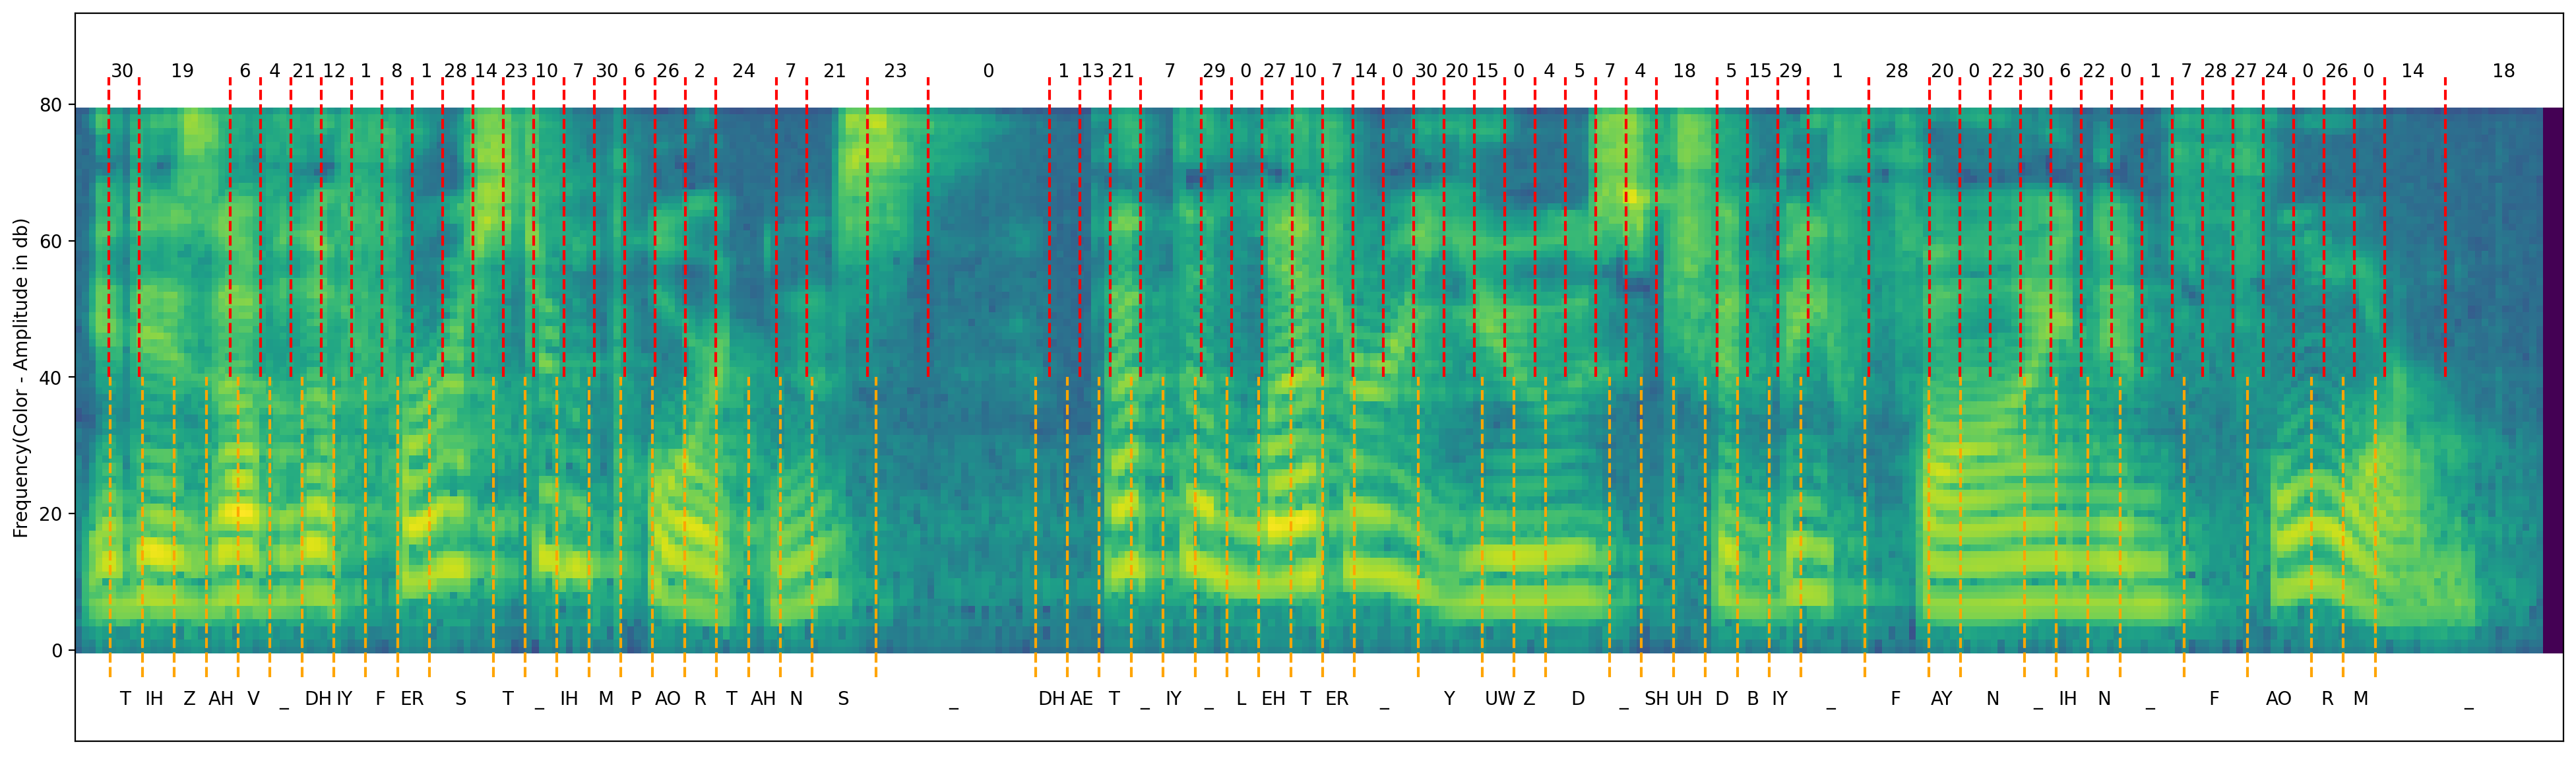

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import statistics 


amp = torchaudio.transforms.AmplitudeToDB()
specgram = torchaudio.transforms.MelSpectrogram(sr, n_mels=80)(waveform.cpu())

ratio = (specgram.shape[2] / len(net.encoding_indices))

fig = plt.figure(figsize=(specgram.shape[2]/15, 8), dpi=200)
plt.imshow(amp(specgram)[0,:,:].numpy())
plt.gca().invert_yaxis()
# plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Frequency(Color - Amplitude in db)')

boundaries = []
old_enc_id = -1
enc_indice_collaps = []
for i, enc_id in enumerate(net.encoding_indices, 1):
    if old_enc_id != enc_id:
        old_enc_id = enc_id
        boundaries.append(ratio*i)
        enc_indice_collaps.append(f"{enc_id.item()}")
                
plt.vlines(boundaries, 40, 84, linestyles='dashed', colors='red')

boundaries += [specgram.shape[2]]
for i, bound in enumerate(boundaries[1:]):
    _x = statistics.median([boundaries[i], bound])
    plt.text(_x-len(enc_indice_collaps[i]), 84, enc_indice_collaps[i], rotation=0)

ratio = (specgram.shape[2] / (len(align)))
boundaries = []
old_align = -1
align_collaps = []
for i, ali in enumerate(align, 1):
    if old_align != ali:
        old_align = ali
        boundaries.append(ratio*i)
        align_collaps.append(f"{ali}")

plt.vlines(boundaries, -4, 40, linestyles='dashed', colors='orange')

boundaries += [specgram.shape[2]]
for i, bound in enumerate(boundaries[1:]):
    _x = statistics.median([boundaries[i], bound])
    plt.text(_x-len(align_collaps[i]), -8, align_collaps[i], rotation=0)        

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1 - 5 ,y2 + 5))
plt.show()

In [15]:
f0 = demo.get_f0(
    waveform.cpu(), f0_stats_file="speech-resynthesis/datasets/LJSpeech/f0_stats.pth"
)
    
for model in models:
    print("Running for codebook size: " + model["dim"])
    out, net = model["asr"](waveform.to(device).clone())
    text = demo.kaldi_asr_decode(out)

    audio = model["synthesis"](net.bottleneck_out.permute(0, 2, 1).contiguous(), f0)
    _,_, repport = demo.ComputeWER(text, text_gt)
    display(HTML(repport, metadata=dict(isolated=True)))
    print(f"Synthesis from ASR bottleneck {model['dim']}: ")
    display(Audio(data=audio, rate=synthesis_sr))

Running for codebook size: no_vq


Synthesis from ASR bottleneck no_vq: 


Running for codebook size: 8


Synthesis from ASR bottleneck 8: 


Running for codebook size: 16


Synthesis from ASR bottleneck 16: 


Running for codebook size: 32


Synthesis from ASR bottleneck 32: 


Running for codebook size: 48


Synthesis from ASR bottleneck 48: 


Running for codebook size: 64


Synthesis from ASR bottleneck 64: 


Running for codebook size: 128


Synthesis from ASR bottleneck 128: 


Running for codebook size: 256


Synthesis from ASR bottleneck 256: 


Running for codebook size: 768


Synthesis from ASR bottleneck 768: 


In [27]:
# F0 quant result
import demo
f0 = demo.get_f0(
    waveform.cpu(), f0_stats_file="speech-resynthesis/datasets/LJSpeech/f0_stats.pth"
)
# print(f0)
print(waveform.shape)
print(f0.shape)
synthesis_gen_model.quantizer.eval()
f0_h = synthesis_gen_model.quantizer.encoder(f0)
# print(synthesis_gen_model.quantizer.decoder)
f0_h = [x.detach() for x in f0_h]
print(f0_h[0].shape)
zs, _, _, _ = synthesis_gen_model.quantizer.vq(f0_h)
zs = [x.detach() for x in zs]
f0_h_q = synthesis_gen_model.f0_dict(zs[0].detach()).transpose(1, 2)
zs

torch.Size([1, 72960])
torch.Size([1, 1, 912])
torch.Size([1, 128, 57])


[tensor([[ 2,  6, 17,  1,  3, 17,  2,  0, 11, 14,  4, 11, 14,  4, 15,  6,  2,  3,
          17,  3,  3, 17, 14,  5,  0, 11,  4, 12,  4, 11, 12, 13,  1,  8, 17,  3,
          17, 17, 19, 10, 17, 17,  8,  9,  8, 19, 19, 19, 15, 17, 10, 12,  9, 14,
          14,  9,  3]], device='cuda:0')]